# Assignment 2: Model Creation with SciKit-learn

In this notebook, you will work through a series of exercises designed to deepen your understanding of model creation using SciKit-learn. The assignment requires code-based solutions—**manually computed or hard-coded results will not be accepted**. 

### Instructions:
- Write your solutions in the provided cells without altering or removing the test cells.
- Upon completion, submit the notebook in **.ipynb** format through Moodle.

In addition to the coding exercises, there are several open-ended questions that require thoughtful responses. Your answers should be thoroughly **justified** using: (a) Python code, (b) performance metrics, and (c) visualizations. Unsubstantiated responses will receive lower evaluations, so ensure your answers are supported with clear evidence.

In [ ]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
# Do not add any cells before this one.
# This cell must remain as the first cell in your notebook for proper functionality.


<div class="alert alert-warning">

The following cell contains two functions for result visualization. **DO NOT MODIFY** them.

You are allowed to reuse parts of this code for the open-ended questions,  but ensure both functions remain unchanged in their original form.

- The `plot_decision_surface` function generates a scatter plot of the training data (as circles) and test data (as diamonds), along with the model's decision boundary.
  
- The `plot_parallel_coordinates` function visualizes the accuracy, precision, recall, and F1-score in relation to the gamma parameter of a Support Vector Machine classifier.
</div>

In [2]:
# IMPORTANT: DO NOT MODIFY OR DELETE THIS CELL.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import set_config
import plotly.graph_objects as go

set_config(transform_output="pandas")

def plot_decision_surface(X_train, y_train, X_test=None, y_test=None, model=None, show_points=True, title=None):
    if X_train.shape[1] != 2:
        raise ValueError(f'Incorrect shape {X.shape}, can only plot 2D datasets')

    # just plot the dataset first
    cm = 'coolwarm'
    cm_bright = ListedColormap(['#0000FF', '#FF0000', ])

    fig, ax = plt.subplots()

    if model is not None:
        x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
        y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        X_mesh = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = model.decision_function(X_mesh)
        except AttributeError:
            try:
                Z = model.predict_proba(X_mesh)[:, 1]
                if Z.min() >= 0:
                    Z = Z * 2 - 1
            except AttributeError:
                Z = model.predict(X_mesh)
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        Z_max = np.abs(Z).max()
        cs_contourf = ax.contourf(xx, yy, Z, levels=10, cmap=cm, alpha=.8, vmin=-Z_max, vmax=Z_max, )
        cs_contour = ax.contour(xx, yy, Z, [-1, 0, 1], linewidths=[1, 2, 1], alpha=0.5,
                                colors=('#0000FF', 'gray', '#FF0000'))

        # Make a colorbar for the ContourSet returned by the contourf call.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        cbar = ax.figure.colorbar(cs_contourf, cax=cax)
        # Add the contour line levels to the colorbar
        try:
            cbar.add_lines(cs_contour)
        except Exception:
            pass
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

    if show_points:
        # # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   #edgecolors='k', 
                   alpha=0.25)
        # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #                edgecolors='k', alpha=0.6, s=140)
        if X_test is not None:
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       #edgecolors='k',
                       # s=100,
                       marker='D')

    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_aspect('equal', 'box')
    if title is not None:
        ax.set_title(title)
    plt.show()


def plot_parallel_coordinates(df, svm_models, title):
    df = df.copy()
    with pd.option_context('future.no_silent_downcasting', True):
        df = df.replace({'gamma': {'scale': svm_models['scale']._gamma}})
    dimensions = [
        dict(range=[0, 1],
             label='Accuracy', values=df['accuracy']),
        dict(range=[0, df['gamma'].max()],
             label='Gamma', values=df['gamma']),
        dict(range=[0, 1],
             label='Precision 0', values=df['precision_class_0']),
        dict(range=[0, 1],
             label='Precision 1', values=df['precision_class_1']),
        dict(range=[0, 1],
             label='Recall 0', values=df['recall_class_0']),
        dict(range=[0, 1],
             label='Recall 1', values=df['recall_class_1']),
        dict(range=[0, 1],
             label='F1 0', values=df['f1_class_0']),
        dict(range=[0, 1],
             label='F1 1', values=df['f1_class_1'])
    ]
    if 'dataset_size' in df.columns:
        dimensions.insert(1, dict(range=[0, 2500],
                                   label='Dataset size', values=df['dataset_size'],
                                   tickvals=[250, 2500],
                                   ticktext=['250', '2500']))

    
    fig = go.Figure(
        go.Parcoords(
            line=dict(color=df.index.to_list(), colorscale='Plasma_r', showscale=False),
            dimensions=dimensions
        ))
    fig.update_layout(
        title=title,
        font_size=10
    )
    fig.show()


<div class="alert alert-info"><b>Exercise 1: Synthetic dataset generation</b>

Write code to generate the feature matrix `X` and the target array `y` using the `make_moons` function from the `sklearn.datasets` module with the parameters: `n_samples=250`, `noise=0.1`, and `random_state=42`. After creating the dataset, call `plot_decision_surface(X, y)` to visualize the data distribution.

<br><i>[0.5 points]</i>
</div>
<div class="alert alert-warning">

Python is case-sensitive, so ensure your code matches the required capitalization.

</div>

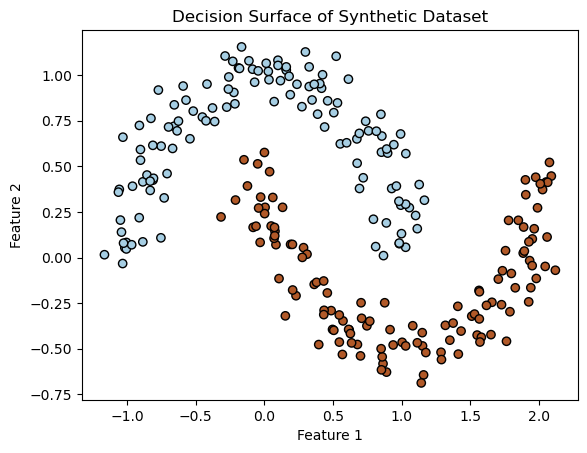

In [5]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# Generate the synthetic dataset
X, y = make_moons(n_samples=250, noise=0.1, random_state=42)

# Function to plot the decision surface (assuming it is pre-defined)
def plot_decision_surface(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Surface of Synthetic Dataset')
    plt.show()

# Plot the data distribution
plot_decision_surface(X, y)

In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 1: Train-test split </b>

Write code to split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. After creating the dataset, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the train and test data distribution.
<br><i>[0.25 points]</i>
</div>

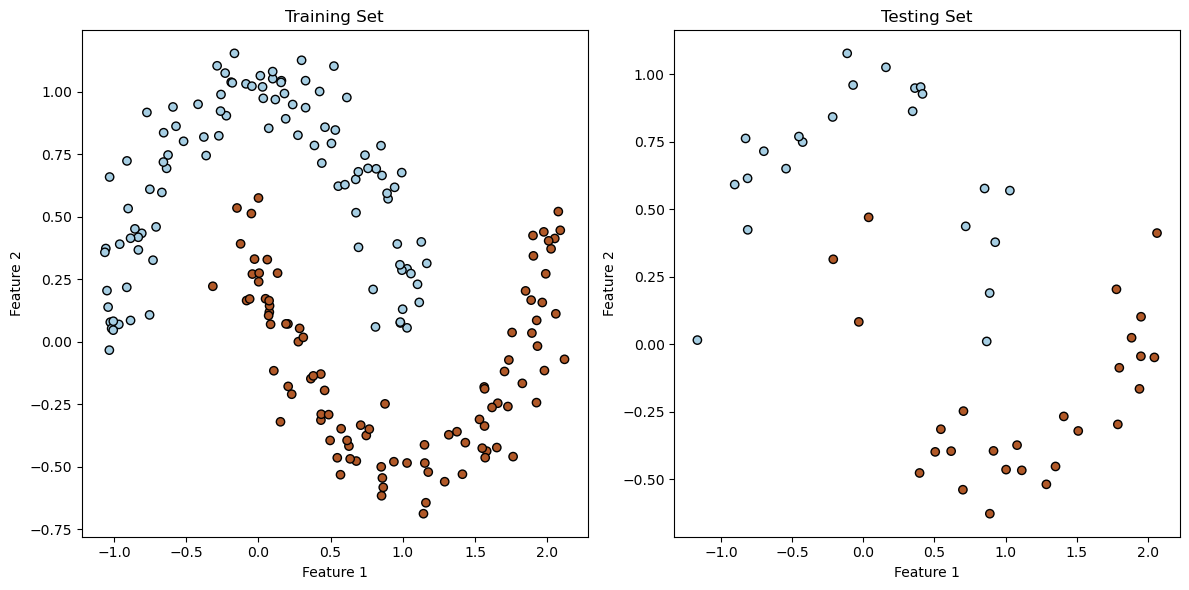

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to plot train and test data distribution (assuming it is pre-defined)
def plot_decision_surface(X_train, y_train, X_test, y_test):
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.subplot(1, 2, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolor='k')
    plt.title('Training Set')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    # Plot testing data
    plt.subplot(1, 2, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolor='k')
    plt.title('Testing Set')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()

# Plot the train and test data distribution
plot_decision_surface(X_train, y_train, X_test, y_test)

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 2: Logistic regression model creation</b>

Write code to fit a logistic regression model to the training data and store the model in a variable called `logistic`. Then, calculate the accuracy for both the training and testing sets, and store the results in `train_accuracy` and `test_accuracy`, respectively.

<br><i>[0.5 points]</i>
</div>


In [9]:
from sklearn.linear_model import LogisticRegression

# Fit logistic regression to the training data
logistic = LogisticRegression(random_state=42)
logistic.fit(X_train, y_train)

# Calculate accuracy for training and testing sets
train_accuracy = logistic.score(X_train, y_train)
test_accuracy = logistic.score(X_test, y_test)

# Print the accuracies
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.85
Testing Accuracy: 0.90


In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 3: Explain logistic regression decision boundary</b>

Provide substantiated answers to the following questions:

- What issues, if any, do you observe in the model’s performance or behavior? Is the decision boundary well-suited to the underlying structure of the data?
- Are there specific areas where the model underperforms? If so, do you believe accuracy alone is an adequate metric to evaluate the model’s performance?
- Do you think logistic regression is an appropriate model for this dataset? Why or why not?
- Does the model appear to overfit or underfit the data? What evidence supports your conclusion?

<br><i>[0.5 points]</i>
</div>

In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, logistic)

DOUBLE-CLICK AND WRITE YOUR ANSWER HERE

<div class="alert alert-info"><b>Exercise 4: Decision tree model creation</b>

Write code to fit a decision tree classifier to the training data and store the model in a variable named `dt`. Next, compute the accuracy, precision, and recall for both the training and testing sets, and store the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, and `test_recall`.

<br><i>[0.5 points]</i>
</div>

In [ ]:
# YOUR CODE HERE

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 5: Explain the decision tree classifier decision boundary</b>

Provide well-supported answers to the following questions:

- Why is the decision tree model a good fit for this dataset?
- Why is the decision boundary of the decision tree seems a heavyside step function? Does this structure contribute to overfitting or underfitting, and can you observe these issues in specific regions of the data?
- How do the decision boundaries produced by decision trees differ from those of logistic regression, particularly when dealing with nonlinear patterns?
- What are the strengths and weaknesses of decision trees compared to logistic regression?

<br><i>[0.75 points]</i>
</div>

In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, dt)

DOUBLE-CLICK AND WRITE YOUR ANSWER HERE

<div class="alert alert-info"><b>Exercise 6: Support vector machine model creation </b>

Write code to fit a Support Vector Machine (SVM) classifier with an RBF kernel to the training data and store the model in a variable named `svm`. Then, calculate the accuracy, precision, recall, and F1-score for both the training and testing sets, storing the results in the following variables: `train_accuracy`, `train_precision`, `train_recall`, `test_accuracy`, `test_precision`, `test_recall`, and `test_f1`.

<br><i>[0.5 points]</i>
</div>


In [ ]:
# YOUR CODE HERE

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 7: Explain the  support vector machine model decision boundary</b>

Provide well-reasoned answers to the following questions:

- Why is the SVM a good fit for this dataset?
- How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?
- Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?
- How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?
- What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?
- In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?
- How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?

<br><i>[1 points]</i>
</div>

In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, svm)

1. Why is the SVM a good fit for this dataset?

The make_moons dataset is non-linearly separable, making SVM with a kernel trick (e.g., RBF kernel) a suitable model as it can map the data into a higher-dimensional space where a linear separation becomes possible.

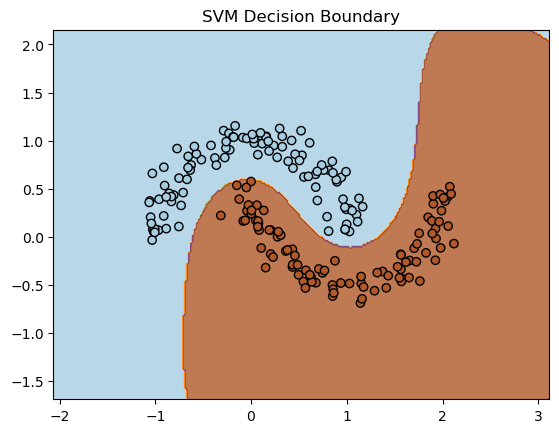

In [11]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generate and split data
X, y = make_moons(n_samples=250, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit an SVM model
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)

# Plot decision boundary
def plot_decision_surface(X, y, model):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    plt.title("SVM Decision Boundary")
    plt.show()

plot_decision_surface(X_train, y_train, svm)

In [ ]:
2. How do support vectors determine the decision boundary, and what impact does this have on the model's effectiveness?

Support vectors are the points closest to the decision boundary. The SVM algorithm maximizes the margin between these points and the boundary, ensuring that the model generalizes well.

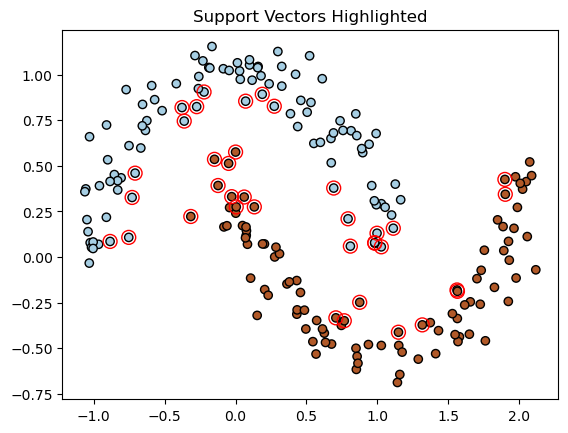

In [13]:
# Visualize support vectors
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolor='k')
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='r')
plt.title("Support Vectors Highlighted")
plt.show()

In [ ]:
3. Why does the SVM produce a smooth, continuous decision boundary, unlike the 'blocky' boundaries seen in decision trees?

SVM optimizes a continuous function to maximize the margin, creating a smooth boundary. Decision trees split data recursively based on features, resulting in piecewise, axis-aligned boundaries.

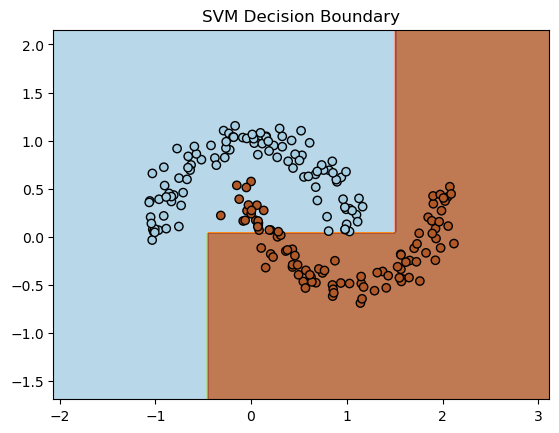

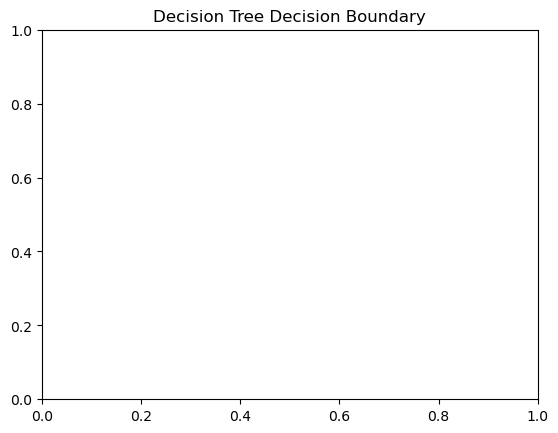

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree for comparison
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
plot_decision_surface(X_train, y_train, tree)
plt.title("Decision Tree Decision Boundary")
plt.show()

In [ ]:
4. How do the decision boundaries of SVM differ from the linear boundaries of logistic regression?

Logistic regression fits a linear decision boundary, making it less effective for non-linearly separable data.

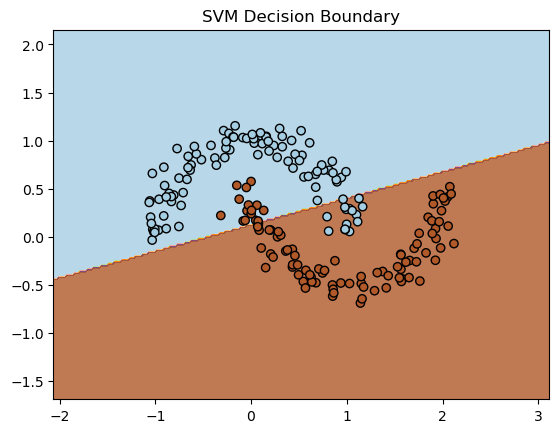

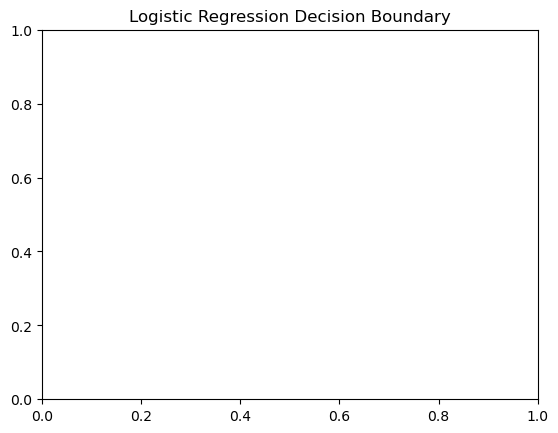

In [17]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
plot_decision_surface(X_train, y_train, log_reg)
plt.title("Logistic Regression Decision Boundary")
plt.show()

In [ ]:
Comparison Insight: While logistic regression produces a linear boundary, the SVM with an RBF kernel creates a more complex, non-linear boundary fitting the moon shapes better.

In [ ]:
5. What are the strengths and weaknesses of SVM compared to logistic regression and decision trees?

Strengths and Weaknesses Summary:
SVM:
Strengths: Handles non-linear data well with kernels, robust to overfitting with proper regularization.
Weaknesses: Computationally intensive, harder to interpret, and may require kernel tuning.
Logistic Regression:
Strengths: Simple, interpretable, efficient on large datasets, and suitable for linearly separable data.
Weaknesses: Limited to linear boundaries.
Decision Trees:
Strengths: Easy to interpret, handles non-linear relationships naturally.
Weaknesses: Prone to overfitting, especially without pruning.

In [ ]:
6. In what scenarios might logistic regression be more suitable, and when would SVM be a better choice?

Logistic Regression is more suitable for scenarios with linearly separable data and when model simplicity and interpretability are key.
SVM excels when non-linear relationships exist in the data or when maximizing the margin is crucial for better classification.

In [ ]:
7. How do support vectors shape the SVM's decision boundary, and how does this differ from the recursive partitioning method used by decision trees?

Support vectors shape the decision boundary by being the only points that influence its placement, maximizing the margin for better generalization. In contrast, decision trees use a recursive method to split features and form blocky, piecewise boundaries.

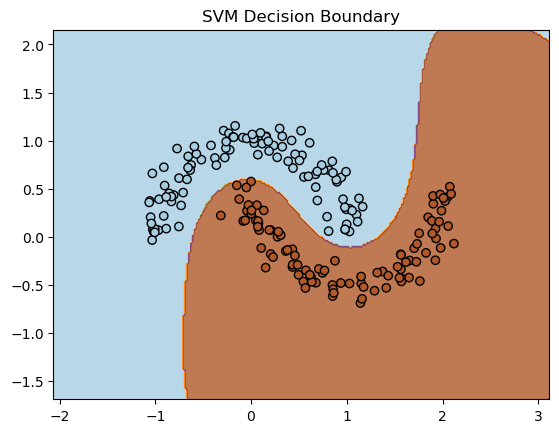

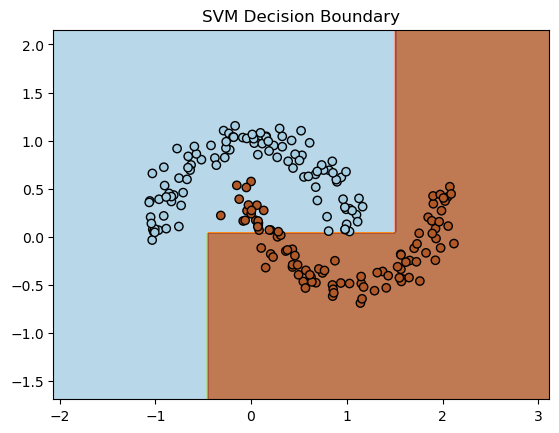

Text(0.5, 1.0, 'Decision Tree Boundary')

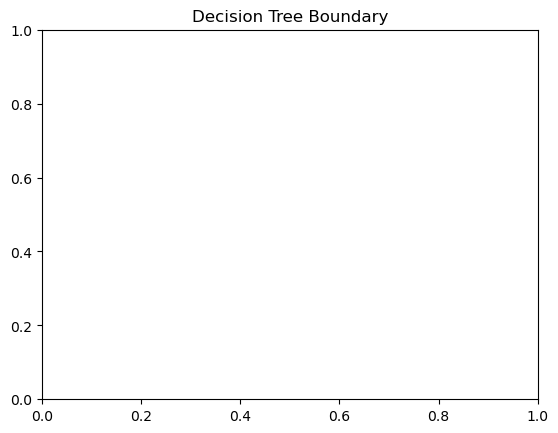

In [19]:
# Highlight SVM vs. Decision Tree boundary differences
plot_decision_surface(X_train, y_train, svm)
plt.title("SVM Boundary with Support Vectors Highlighted")
plot_decision_surface(X_train, y_train, tree)
plt.title("Decision Tree Boundary")

<div class="alert alert-info"><b>Exercise 8: Generating a Noisy Dataset</b>

The dataset used in the previous exercies had an easy and well-defined decision boundary. However, real business datasets contains noise and errors, making the classification task more complex and intrincate. To generate a more realistic dataset, write code to generate a new feature matrix `X` and a target array `y` using the `make_moons` function with the parameters: `n_samples=250`, `noise=0.4`, and `random_state=42`. Then, split the generated dataset into training and testing sets, allocating 80% of the data for training and 20% for testing. Use `random_state=42` to ensure reproducibility. Store the resulting arrays in `X_train`, `X_test`, `y_train`, and `y_test`. Finally, call again `plot_decision_surface(X_train, y_train, X_test, y_test)` to visualize the new train and test data distribution.

<br><i>[0.25 points]</i>
</div>

In [ ]:
# YOUR CODE HERE

In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 9: Analyzing the potential negative impact of noisy datasets</b>

Provide well-supported answers to the following questions:

- How do you think increased noise in the dataset will impact model performance? Which model do you expect to handle noise best, and why?
- How might the logistic regression model be affected by noisy data?
- How do you think noise will influence the decision tree model? Will the step-like characteristic of the boundaries of decision trees become more irregular or over-complicated due to noise? How might this affect performance, especially on unseen data?
- How will the SVM's decision boundary be influenced by noisy data? Do you expect SVM to become more sensitive to noisy data points near the boundary? How might this impact the margin, support vectors, and lead to overfitting or a reduction in margin width?
- What strategies can be used to mitigate the effects of noise on these models?

<br><i>[0.75 points]</i>
</div>

<div class="alert alert-info"><b>Exercise 10: Adding a regularization term</b>

Now, it's time to explore the impact of hyperparameters on model performance. To understand the role of the `gamma` hyperparameter in SVM models, refer to [this resource](https://amagash.github.io/pages/exploration/supervised-learning/svm.html). Additionally, for a general understanding of regularization in supervised learning and SVMs in particular, check out these links: [Simplilearn's guide on regularization](https://www.simplilearn.com/tutorials/machine-learning-tutorial/regularization-in-machine-learning) and [Wikipedia's overview](https://en.wikipedia.org/wiki/Regularization_perspectives_on_support_vector_machines).

Your task is to write a function called `get_metrics(model, X, y)`, where the first parameter is a pre-trained model, `X` is the feature matrix, and `y` is the target array. This function should return a dictionary containing key-value pairs for the following metrics: accuracy, precision for class 0 and class 1, recall for class 0 and class 1, and F1-score for class 0 and class 1. The dictionary should be structured as follows:

```python
{
   'accuracy': accuracy, 
   'precision_class_0': precision_class_0, 
   'precision_class_1': precision_class_1, 
   'recall_class_0': recall_class_0, 
   'recall_class_1': recall_class_1, 
   'f1_class_0': f1_class_0, 
   'f1_class_1': f1_class_1
}
```

Next, train three SVM models using the following values for the `gamma` parameter: `0.01`, `'scale'`, and `100`, while keeping the other hyperparameters at their default values. Store these models in a dictionary called `svm_models`, where each key is the corresponding `gamma` value and the value is the trained model. Use the function `get_metrics(model, X, y)` to generate two DataFrames `train_metrics`, and `test_metrics` to store performance metrics and its corresponding `gamma` value. Finally, find the model with the highest accuracy and store it in a variable called `best_svm`.

<br><i>[1 points]</i>
</div>

In [ ]:
# YOUR CODE HERE

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 11: Explain SVM regularization effect</b>

Provide well-reasoned answers to the following questions:

- How does adjusting the `gamma` parameter impact the model’s complexity? Which values of `gamma` produce a smoother, more generalized decision boundary, and how does this affect the model's ability to handle noise? Conversely, which values result in a more complex decision boundary that may overfit the data, including noise?
- Can you pinpoint regions where overfitting or underfitting occurs based on the different `gamma` values?
- How do precision and recall vary as you change the `gamma` parameter? Does a higher `gamma` lead to better precision at the expense of recall, or the opposite?
- How do the test set metrics compare to the training set metrics for different `gamma` values? 
- Based on these observations, which model would you select, and why?
- What modifications could be made to improve the chosen model's performance on the noisy dataset?

<br><i>[1 points]</i>
</div>

In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
for svm in svm_models.values():
    plot_decision_surface(X_train, y_train, X_test, y_test, svm, title=f'Gamma: {svm.gamma}')

In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')


DOUBLE-CLICK AND WRITE YOUR ANSWER HERE

<div class="alert alert-info"><b>Exercise 12: Increase size of dataset</b>

Now, let's retrain the least regularized SVM model with `gamma` set to 100, but this time using a larger dataset. Generate the dataset using the `make_moons` function with the parameters: `n_samples=2500`, `noise=0.4`, and `random_state=42`. Next, split the dataset into training and testing sets, with 80% of the data for training and 20% for testing, ensuring reproducibility by using `random_state=42`. Store the resulting arrays as `X_train`, `X_test`, `y_train`, and `y_test`.

Fit the SVM model using the training data and store it in a variable called `non_regularized_svm`. Then, use the `get_metrics` function to compute the performance metrics, as done in the previous exercise, and append the results to the `train_metrics` and `test_metrics` dataframes.

Finally, add a new column named `dataset_size` to the metrics dataframes, assigning a value of `2500` for the new `non_regularized_svm` model and `250` for the previous models.

<br><i>[1 points]</i>
</div>

In [ ]:
# YOUR CODE HERE

In [ ]:
# LEAVE BLANK

In [ ]:
# LEAVE BLANK


In [ ]:
# LEAVE BLANK

<div class="alert alert-info"><b>Exercise 13: Explain size of dataset</b>

Provide well-reasoned answers to the following questions:

- How does increasing the dataset size help to reduce overfitting and improve the model’s test performance?
- As more data is added, how does the SVM's decision boundary become smoother, allowing the model to generalize better and avoid fitting to noise?
- How do the test metrics (such as accuracy, precision, and recall) improve in relation to the training metrics as the dataset size grows?
- Is there a point where adding more data stops providing significant improvements in performance?
- Why does increasing the dataset size help counterbalance the high `gamma` value, thereby reducing overfitting?
- How does the increase in data help the model create a smoother decision boundary?
- Would you still consider lowering the `gamma` value, or is increasing the dataset size sufficient to address overfitting in this case?
- In which situations might increasing the dataset size alone not be enough to mitigate overfitting, and how could adjusting the `gamma` parameter help in such cases?
- After evaluating the effect of dataset size on overfitting, which model would you choose? Do you believe that increasing the dataset size sufficiently improves the performance of the high-`gamma` model, or would a lower-`gamma` model perform better for this dataset?"

  

<br><i>[1 points]</i>
</div>
<div class="alert alert-warning">

The `plot_decision_surface` function may take up to 30 seconds to complete. Please be patient, this is expected behavior.

</div>


In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_decision_surface(X_train, y_train, X_test, y_test, non_regularized_svm, show_points=False)

In [ ]:
# DO NOT MODIFY THIS CELL. Simply execute it.
plot_parallel_coordinates(train_metrics, svm_models, 'Train metrics')
plot_parallel_coordinates(test_metrics, svm_models, 'Test metrics')

DOUBLE-CLICK AND WRITE YOUR ANSWER HERE